# Modèles pour la data : données manquantes
## Author: Thierry KHAMPHOUSONE, Classe TC-44, IA-1
### 15/03/2021

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import mkl, multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import timeit
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

## 1) Chargement et analyse préliminaire des données

### a) Après avoir pris connaissance du dataset (auto-mpg-dataset.txt) et de sa description (auto- mpg-description.txt), indiquez pour chaque colonne si la variable est qualitative ou quantitative.

1. mpg (miles per gallon) \[**Variable quantitative**\]
2. cylinders \[**Variable qualitative ordinale**\]
3. displacement \[**Variable quantitative**\]
4. horsepower \[**Variable quantitative**\]
5. weight \[**Variable quantitative**\]
6. acceleration \[**Variable quantitative**\]
7. model year \[**Variable qualitative nominale**\]
8. origin (1. america, 2: europe, 3: asia) \[**Variable qualitative nominale**\]
9. car name \[**Variable qualitative nominale**\]

### b) Charger les données à partir du fichier texte contenant le dataset. L’objectif est de parvenir à un objet pandas.DataFrame.

In [2]:
def set_df_data_types(df):
    # convert into qualitative data
    df['cylinders'] = df['cylinders'].astype(str);
    df['model year'] = df['model year'].astype(str);
    df['origin'] = df['origin'].astype(str);
    df['car name'] = df['car name'].astype(str);

    # convert into quantitative data
    df['mpg'] = df['mpg'].astype('float64');
    df['displacement'] = df['displacement'].astype('float64');
    df['horsepower'] = df['horsepower'].astype('float64');
    df['weight'] = df['weight'].astype('float64');
    df['acceleration'] = df['acceleration'].astype('float64');
    return df



In [3]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
df = pd.read_csv('../Dataset/auto-mpg-dataset.txt', names=column_names, delim_whitespace=True)


In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [5]:
np.shape(df)

(406, 9)

In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
df.dtypes

mpg             float64
cylinders       float64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year      float64
origin          float64
car name         object
dtype: object

J'ai bien chargé les données à partir du fichier texte contenant le dataset au sein d'un objet Pandas.DataFrame: la taille de l'échantillon est 406 et le nombres de features est 9.

Les types de données (qualitative/quantitative) ont été correctement modifiées

### c) Déterminer pour chaque colonne, à l’aide d’une fonction, le nombre de valeurs manquantes et leur taux (# valeurs manquantes/# valeurs total).

In [8]:
def get_number_missing_data(df):
    '''
    retourne le dataframe du nombre de données manquantes pour chaque colonne
    '''
    try:
        return df.isnull().sum()
    except:
        return 'No missing data'

In [9]:
def get_ratio_missing_data(df):
    '''
    retourne le dataframe de ratio de nombre de données manquantes pour chaque colonne
    '''
    miss_df = df.isnull().sum()
    return np.round(miss_df/int(np.shape(df)[0]), 3)

Nous avons ici 8 données manquantes pour la feature 'mpg' et 6 données manquantes pour la feature 'horsepower'

### d) Représenter graphiquement les données à l’aide de plusieurs nuages de points en deux dimensions.
L’axe vertical devra correspondre à la consommation (première colonne) et l’axe horizontal de- vra correspondre successivement à toutes les autres variables quantitatives.

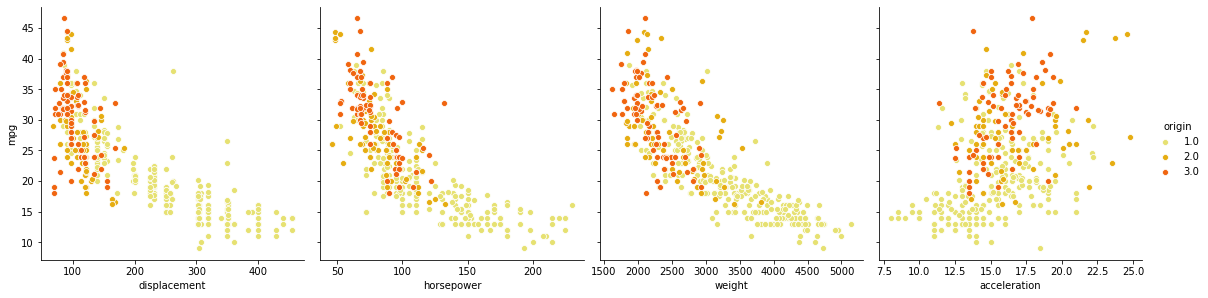

In [10]:
sns.pairplot(
    df, 
    x_vars=['displacement', 'horsepower', 'weight', 'acceleration'],
    y_vars=['mpg'],
    hue='origin',
    palette=sns.color_palette("CMRmap_r"),
    markers='o',
    height=4,
    dropna=False
);


## 2) Transformation du dataset : variation du taux de données manquantes

Vous avez sans doute remarqué que le nombre de données manquantes dans ce dataset est rela-
tivement faible.

Afin de pouvoir mettre en œuvre les méthodes présentées en cours et dans la suite de cette activi- té et de pouvoir étudier leur efficacité, nous nous proposons de venir augmenter artificiellement cette proportion, à un taux arbitraire en venant supprimer des données présentes.

1. une première qui supprimera aléatoirement des données dans une colonne donnée, de façon à ce que le taux de valeurs manquantes pour cette variable devienne égal à une valeur fixée arbitrairement par l’utilisateur

Attention : il faut prendre en compte les données qui sont déjà manquantes avant la suppression pour le calcul du taux final de valeurs manquantes.

In [11]:
def delete_data_column_at_ratio(df, column, ratio):
    '''
    retourne un nouveau dataframe avec les données supprimées pour la colonne souhaité au ratio voulue
    '''
    miss_df = df.isnull().sum()
    size = np.shape(df)[0]

    # nombre de données manquantes hors déjà manquantes
    nb_data2delete = np.round(ratio*size - miss_df, 1).astype(int)[column] 
    # indice des données déjà manquantes
    already_nan = list(df[df.iloc[:, column].isna()].index.values)


    temp = np.arange(size) # index from 0 to nb of row of the dataframe
    temp2 = np.delete(temp, already_nan) # delete index where data is already nan
    np.random.shuffle(temp2) # shuffle to make a random
    index2delete = temp2[:nb_data2delete] # get random indexes to delete
    new_df = df.copy() # deep copy 

    for value in index2delete:
        new_df.iloc[value, column] = np.nan # delete value
    return new_df


In [12]:
# Exemple d'utilisation 
# on supprime des données de la colonne weight de façon a perdre 40% des données
new_df = delete_data_column_at_ratio(df, 4, 0.40)

# on a bien un ratio de 0.40 de données manquantes
print('Ratio du nombre de données manquantes pour chaque colonne')
print(get_ratio_missing_data(new_df), '\n')

# on a supprimé au total 162 données.
print('Nombre de données manquantes pour chaque colonne')
print(get_number_missing_data(new_df))



Ratio du nombre de données manquantes pour chaque colonne
mpg             0.020
cylinders       0.000
displacement    0.000
horsepower      0.015
weight          0.399
acceleration    0.000
model year      0.000
origin          0.000
car name        0.000
dtype: float64 

Nombre de données manquantes pour chaque colonne
mpg               8
cylinders         0
displacement      0
horsepower        6
weight          162
acceleration      0
model year        0
origin            0
car name          0
dtype: int64


2. une seconde qui supprimera aléatoirement des données dans l’ensemble du dataframe (n’importe quelle colonne peut donc être concernée) de façon à ce que le taux de valeurs manquantes, au total, devienne égal à une valeur fixée arbitrairement par l’utilisateur.

Attention : il faut prendre en compte les données qui sont déjà manquantes avant la suppression pour le calcul du taux final de valeurs manquantes.

In [13]:
def delete_random_data(df, ratio):
    '''
    retourne un nouveau dataframe avec les données supprimées (toutes les colonnes confondues) souhaité au ratio voulue.
    '''
    miss_df = df.isnull().sum()
    size = np.shape(df)[0]
    nb_data_already_missing = miss_df.sum()

    # nombre de données manquantes hors déjà manquantes
    nb_data2delete = np.round(ratio*size - nb_data_already_missing, 1).astype(int)

    # Passage du dataframe en dataframe 1 dimension
    flattened_df = df.values.flatten()
    temp_df = pd.DataFrame(flattened_df, columns=['temp'])

    # indice des données déjà manquantes dans la liste 
    already_nan = list(temp_df[temp_df.iloc[:, 0].isna()].index.values)
    
    # Suppression aléatoire
    temp = np.arange(np.shape(temp_df)[0]) # index from 0 to the nb of row of the dataframe
    temp2 = np.delete(temp, already_nan) # delete index where data is already nan
    np.random.shuffle(temp2) # shuffle to make a random
    index2delete = temp2[:nb_data2delete] # get random indexes to delete
    new_df = temp_df.copy() # deep copy 
    for value in index2delete:
        new_df.iloc[value, 0] = np.nan # delete value

    # reformatage en Dataframe
    flattened_df = new_df.values.flatten()
    array_reshaped = flattened_df.reshape(np.shape(df)[0], np.shape(df)[1])
    new_df = pd.DataFrame(array_reshaped, columns=df.columns)
    
    return new_df

In [14]:
# Exemple d'utilisation 
# on supprime des données de façon a perdre 40% des données
new_df2 = delete_random_data(df, 0.40)

# on a bien un ratio de 0.40 de données manquantes
print('Ratio du nombre de données manquantes pour chaque colonne')
print(get_ratio_missing_data(new_df2), '\n')

print('Ratio du nombre de données manquantes totale')
print(get_ratio_missing_data(new_df2).sum(), '\n')

# on a supprimé au total 162 données.
print('Nombre de données manquantes pour chaque colonne')
print(get_number_missing_data(new_df2))

Ratio du nombre de données manquantes pour chaque colonne
mpg             0.047
cylinders       0.044
displacement    0.034
horsepower      0.044
weight          0.049
acceleration    0.044
model year      0.039
origin          0.039
car name        0.057
dtype: float64 

Ratio du nombre de données manquantes totale
0.39699999999999996 

Nombre de données manquantes pour chaque colonne
mpg             19
cylinders       18
displacement    14
horsepower      18
weight          20
acceleration    18
model year      16
origin          16
car name        23
dtype: int64


## 3) Utilisation de méthodes avec suppression de données

Dans cette partie, on propose de régler le problème des données manquantes en se limitant aux données disponibles, en réalisant soit une analyse des cas concrets, ou une analyse de cas disponibles.
Vous devrez donc écrire deux fonctions :


1. Analyse des cas concrets : la fonction prend en entrée le dataframe et ne renvoie que les lignes qui ne comportent pas de données manquantes.

In [15]:
def analyse_cas_concret(df):
    return df.dropna().reset_index(drop=True).copy()

In [16]:
print('Nombre de données manquantes totale')
print(get_number_missing_data(df).sum(), '\n')

new_df3 = analyse_cas_concret(df)

print('on a bien retiré les lignes où les données étaient manquantes')
print('df initial - df cas concret:',df.shape[0] - new_df3.shape[0])

Nombre de données manquantes totale
14 

on a bien retiré les lignes où les données étaient manquantes
df initial - df cas concret: 14


2. Analyse des données disponibles : la fonction prend en entrée le dataframe et un taux maximal, et renvoie une copie des données où les variables dont le taux de valeurs manquantes (cf. 2.1) dépassant ce taux ont été retirées.

In [17]:
def analyse_data_disponible(df, ratio_max, verbose=False):
    if verbose:
        print('Delete column if nb of Nan > {}'.format(int(np.round(ratio_max*df.shape[0]))))
    return df.dropna(axis='columns', thresh=int(np.round(df.shape[0]-ratio_max*df.shape[0]))).copy()

In [18]:
print('Nombre de données manquantes pour chaque colonne')
print(get_number_missing_data(df))
print('df initial:',df.shape, '\n')

print('Avec un seuil de 0.017 correspondant à 7 nan, on a bien supprimé 1 colonne (mpg)', '\n')
new_df4 = analyse_data_disponible(df, 0.017, verbose=True)
print('df data disponible:', new_df4.shape)
print(list(new_df4.columns))

print('Avec un seuil de 0.017 correspondant à 7 nan, on a bien supprimé 2 colonnes (mpg et horsepower)', '\n')
new_df4 = analyse_data_disponible(df, 0.010, verbose=True)
print('df data disponible:', new_df4.shape)
print(list(new_df4.columns))

Nombre de données manquantes pour chaque colonne
mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64
df initial: (406, 9) 

Avec un seuil de 0.017 correspondant à 7 nan, on a bien supprimé 1 colonne (mpg) 

Delete column if nb of Nan > 7
df data disponible: (406, 8)
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
Avec un seuil de 0.017 correspondant à 7 nan, on a bien supprimé 2 colonnes (mpg et horsepower) 

Delete column if nb of Nan > 4
df data disponible: (406, 7)
['cylinders', 'displacement', 'weight', 'acceleration', 'model year', 'origin', 'car name']


## 4) Utilisation de méthodes avec imputation de données
Dans cette partie, on propose de régler le problème des données manquantes en les complétant en fixant leur valeur à l’aide d’une méthode d’imputation.

### 4.1.) Imputation univariée
Après avoir rappelé le principe et le fonctionnement d’une imputation univariée, utiliser la classe sklearn.impute.SimpleImputer pour compléter les données manquantes, en essayant différentes stratégies d’imputation.
Discuter de son intérêt, et de ses limitations potentielles.

**Fonctionnement d'une imputation univariée**: L'imputation univariée signifie le fait d'ajouter des valeurs manquantes par une valeur aux colonnes du dataframe. Plusieurs stratégie d'imputation univariée existent, par exemple par la moyenne, la mediane, la valeur la plus fréquente.

In [19]:
def get_missing_data_indexes_at_column(df, column):
    return list(df[df.iloc[:, column].isna()].index.values)

In [20]:
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(new_df2), '\n')
print('Index des données manquantes:')

[print('['+new_df2.columns[i]+' index]', get_missing_data_indexes_at_column(new_df2, i)) for i in range(new_df2.shape[1])]
print('\n')

Nombre de données manquantes pour chaque colonne:
mpg             19
cylinders       18
displacement    14
horsepower      18
weight          20
acceleration    18
model year      16
origin          16
car name        23
dtype: int64 

Index des données manquantes:
[mpg index] [10, 11, 12, 13, 14, 17, 31, 39, 86, 93, 123, 190, 214, 251, 280, 326, 367, 370, 394]
[cylinders index] [2, 4, 27, 42, 49, 63, 91, 98, 106, 111, 125, 137, 201, 222, 261, 264, 290, 296]
[displacement index] [46, 83, 102, 106, 133, 170, 184, 190, 222, 244, 273, 275, 329, 389]
[horsepower index] [38, 86, 111, 115, 133, 142, 145, 152, 174, 204, 309, 327, 337, 343, 355, 357, 361, 382]
[weight index] [119, 138, 152, 163, 166, 186, 189, 194, 215, 219, 252, 273, 275, 276, 282, 287, 354, 358, 364, 385]
[acceleration index] [17, 18, 21, 34, 51, 59, 72, 91, 159, 167, 169, 176, 244, 268, 270, 332, 340, 396]
[model year index] [6, 13, 55, 56, 63, 91, 164, 198, 210, 213, 279, 298, 339, 358, 367, 369]
[origin index] [5, 24, 32,

In [21]:
# imputation par le plus fréquent
print('--- Imputation par le plus fréquent ---')
df_imputation_frequent = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(new_df2), columns=new_df2.columns)

print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df_imputation_frequent), '\n')
# on a bien imputé les manquants

print('Données imputées aux index des données manquantes:')
[print('['+new_df2.columns[i]+' index]') or print(df_imputation_frequent.iloc[get_missing_data_indexes_at_column(new_df2, i), i], '\n') for i in range(new_df2.shape[1])]
print('---------------------------------------', '\n\n')

--- Imputation par le plus fréquent ---
Nombre de données manquantes pour chaque colonne:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64 

Données imputées aux index des données manquantes:
[mpg index]
10     13
11     13
12     13
13     13
14     13
17     13
31     13
39     13
86     13
93     13
123    13
190    13
214    13
251    13
280    13
326    13
367    13
370    13
394    13
Name: mpg, dtype: object 

[cylinders index]
2      4
4      4
27     4
42     4
49     4
63     4
91     4
98     4
106    4
111    4
125    4
137    4
201    4
222    4
261    4
264    4
290    4
296    4
Name: cylinders, dtype: object 

[displacement index]
46     97
83     97
102    97
106    97
133    97
170    97
184    97
190    97
222    97
244    97
273    97
275    97
329    97
389    97
Name: displacement, dtype: object 

[horsepower index]
38     150
86     150
11

In [22]:
# imputation par la moyenne (uniquement sur les données dont les variables aléatoires sont quantitatives)
new_df2_mean = set_df_data_types(new_df2.copy()).select_dtypes([np.number])

print('--- Imputation par la moyenne ---')
df_imputation_mean = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(new_df2_mean), columns=new_df2_mean.columns.values.tolist())
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df_imputation_mean), '\n')
print('Données imputées aux index des données manquantes:')
[print('['+new_df2_mean.columns.values.tolist()[i]+' index]') or print(df_imputation_mean.iloc[get_missing_data_indexes_at_column(new_df2_mean, i), i], '\n') for i in range(new_df2_mean.shape[1])]
print('---------------------------------------', '\n\n')

--- Imputation par la moyenne ---
Nombre de données manquantes pour chaque colonne:
mpg             0
displacement    0
horsepower      0
weight          0
acceleration    0
dtype: int64 

Données imputées aux index des données manquantes:
[mpg index]
10     23.514987
11     23.514987
12     23.514987
13     23.514987
14     23.514987
17     23.514987
31     23.514987
39     23.514987
86     23.514987
93     23.514987
123    23.514987
190    23.514987
214    23.514987
251    23.514987
280    23.514987
326    23.514987
367    23.514987
370    23.514987
394    23.514987
Name: mpg, dtype: float64 

[displacement index]
46     194.873724
83     194.873724
102    194.873724
106    194.873724
133    194.873724
170    194.873724
184    194.873724
190    194.873724
222    194.873724
244    194.873724
273    194.873724
275    194.873724
329    194.873724
389    194.873724
Name: displacement, dtype: float64 

[horsepower index]
38     105.569588
86     105.569588
111    105.569588
115    105.569

In [23]:
# imputation par la mediane (uniquement sur les données dont les variables aléatoires sont quantitatives)
new_df2_median = set_df_data_types(new_df2.copy()).select_dtypes([np.number])

print('--- Imputation par la mediane ---')
df_imputation_median = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(new_df2_median), columns=new_df2_median.columns.values.tolist())
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df_imputation_median), '\n')
print('Données imputées aux index des données manquantes:')
[print('['+new_df2_median.columns.values.tolist()[i]+' index]') or print(df_imputation_median.iloc[get_missing_data_indexes_at_column(new_df2_median, i), i], '\n') for i in range(new_df2_median.shape[1])]
print('---------------------------------------', '\n\n')

--- Imputation par la mediane ---
Nombre de données manquantes pour chaque colonne:
mpg             0
displacement    0
horsepower      0
weight          0
acceleration    0
dtype: int64 

Données imputées aux index des données manquantes:
[mpg index]
10     23.0
11     23.0
12     23.0
13     23.0
14     23.0
17     23.0
31     23.0
39     23.0
86     23.0
93     23.0
123    23.0
190    23.0
214    23.0
251    23.0
280    23.0
326    23.0
367    23.0
370    23.0
394    23.0
Name: mpg, dtype: float64 

[displacement index]
46     151.0
83     151.0
102    151.0
106    151.0
133    151.0
170    151.0
184    151.0
190    151.0
222    151.0
244    151.0
273    151.0
275    151.0
329    151.0
389    151.0
Name: displacement, dtype: float64 

[horsepower index]
38     95.0
86     95.0
111    95.0
115    95.0
133    95.0
142    95.0
145    95.0
152    95.0
174    95.0
204    95.0
309    95.0
327    95.0
337    95.0
343    95.0
355    95.0
357    95.0
361    95.0
382    95.0
Name: horsepower,

In [24]:
# imputation par une constante
print('--- Imputation par constante ---')
df_imputation_constant = pd.DataFrame(SimpleImputer(missing_values=np.nan, fill_value=[18.0, 8.0, 340.0, 215.0, 4321.0, 5.0, 70.0, 1.0, 'ford maverick'],strategy='constant').fit_transform(new_df2), columns=new_df2.columns)

print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df_imputation_constant), '\n')
# on a bien imputé les manquants

print('Données imputées aux index des données manquantes:')
[print('['+new_df2.columns[i]+' index]') or print(df_imputation_constant.iloc[get_missing_data_indexes_at_column(new_df2, i), i], '\n') for i in range(new_df2.shape[1])]
print('---------------------------------------', '\n\n')

--- Imputation par constante ---
Nombre de données manquantes pour chaque colonne:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64 

Données imputées aux index des données manquantes:
[mpg index]
10     18.0
11     18.0
12     18.0
13     18.0
14     18.0
17     18.0
31     18.0
39     18.0
86     18.0
93     18.0
123    18.0
190    18.0
214    18.0
251    18.0
280    18.0
326    18.0
367    18.0
370    18.0
394    18.0
Name: mpg, dtype: object 

[cylinders index]
2      8.0
4      8.0
27     8.0
42     8.0
49     8.0
63     8.0
91     8.0
98     8.0
106    8.0
111    8.0
125    8.0
137    8.0
201    8.0
222    8.0
261    8.0
264    8.0
290    8.0
296    8.0
Name: cylinders, dtype: object 

[displacement index]
46     340.0
83     340.0
102    340.0
106    340.0
133    340.0
170    340.0
184    340.0
190    340.0
222    340.0
244    340.0
273    340.0
275    34

#### **Stratégie:** imputation par le plus fréquent  
  
**Intérêt:** Permet de remplir les données manquantes dans un dataframe par la valeur la plus fréquente de la variable aléatoire, cela nous permettrait de ne pas remplir par une valeur aléatoire ou qui n'a rien à voir avec les données actuelles.   
  
**Limitations potentielles:** Si la valeur la plus fréquente a une valeur très élevée ou très faible, le fait d'imputer des données par stratégie 'le plus fréquent' va faire varier la moyenne très facilement. Etant donné que l'écart-type est sensible aux valeurs aberrantes, elle peut se retrouver déformée (elle se rapproche de 0 si les valeurs imputées sont proches de la moyenne et inversement, elle s'éloigne de 0 si les valeurs imputées sont aux extremités)  

---

#### **Stratégie:** imputation par la moyenne
  
**Intérêt:** Permet de remplir les données manquantes dans un dataframe par la valeur moyenne de la variable aléatoire, cela nous permettrait encore une fois de ne pas imputer par une valeur aléatoire.   
  
**Limitations potentielles:** Imputer par la moyenne peut poser problème si la variable aléatoire prend beaucoup de valeurs extremes et peu de valeurs centrées sur la moyenne. De ce fait, imputer par la valeur moyenne revient à ajouter des valeurs qui n'ont rien à voir avec les données actuelles. 

---

#### **Stratégie:** imputation par la mediane  
  
**Intérêt:** Permet de remplir les données manquantes dans un dataframe par la valeur moyenne de la variable aléatoire, cela nous permettrait encore une fois de ne pas imputer par une valeur aléatoire mais par une valeur déjà existante pour la variable aléatoire. De plus la mediane n'est pas sensible aux valeurs extremes.  
  
**Limitations potentielles:** Imputer par la mediane peut poser problème si le dataframe possede beaucoup de manquants centrées autour de la moyenne et très peu autour. De ce fait la mediane va se situer soit à l'extreme basse, soit à l'extreme haute. Donc imputer des données d'une valeur très grande ou très faible va avoir un impact sur l'ensemble du dataframe et ne sera plus représentatif.  

---

#### **Stratégie:** imputation par constante
  
**Intérêt:** Permet de remplir les données manquantes dans un dataframe par une valeur constate, cela nous permettrait encore une fois de ne pas imputer par une valeur aléatoire mais par une valeur choisie.
  
**Limitations potentielles:** Imputer par une constante peut poser problèmes si la constante est une valeur aberrante. S'il a beaucoup de données manquantes pour une variable aléatoire, ajouter une valeur constante peut potentiellement modifier la position et la dispersion des données du dataframe.  

---

#### Conclusion : Les méthodes à imputation unique ne tiennent pas compte de l'incertitudes des données imputées car nous imputons une donnée manquante seulement une fois et nous supponsons que ces données auraient été ce qui aurait du être observé si le dataframe était au complet. Il serait plus intéressant d'avoir plusieurs valeurs possibles et d'avoir plusieurs versions de dataframe avec les données imputées. 

### 4.2.) Imputation par la méthode des k plus proches voisins (kNN)
Il est possible de réaliser l’imputation en utilisant l’algorithme des k plus proches voisins.  
La solution consiste, pour une instance présentant une (ou plusieurs) donnée(s) manquante(s), à rechercher ses k plus proches voisins (au sens d’une métrique donnée). Ces derniers seront utilisés pour imputer les valeurs manquantes en effectuant une moyenne (éventuellement pondérée selon la distance) des variables concernées.  
Nous utiliserons la classe sklearn.impute.KNNImputer qui permet de mettre en œuvre cette méthode d’imputation.

a) Expliquer le fonctionnement de la métrique par défaut utilisée par cette classe pour déterminer ses plus proches voisins.

**Fonctionnement de la métrique par défaut: nan_euclidiant**   
Utilisation de l'algortihme K-nn en utilisant la distance euclidienne et en choisissant le nombre de voisins voulu.  
1. L'algorithme K-nn appliqué à l'imputation des données pour un exemple (une ligne du dataframe possedant 1 manquant par exemple) va sélectionner les n plus proches voisins que nous définirons grâce à la distance euclidienne.  
2. Il va ensuite pouvoir imputer la donnée manquante en calculant la moyenne pondérée ou non pondérée des voisins. 

Par exemple nous avons :  
    \[1   2   3\],  
    \[NaN 5   -1\],  
    \[9   7   12\],  
    \[3   5   -2\],  

En utilisant l'algorithme K-nn avec la distance euclidienne, les moyennes pondérées et un nombre de voisin égal à 2:  
Nous allons comparer 2 voisins :  
**\[1   2   7\]**  et  **\[3   5   -2\]** car ils ont une distance euclidienne la plus faible par rapport à  **\[NaN 5   -1\]**  

=> De ce fait, **NaN** va pouvoir être remplacé par : **(1*3)/2 = 1.5**

Nous obtenons ainsi notre dataframe **imputé par K-nn**:  
    \[1   2   3\],  
    \[1.5 5   -1\],  
    \[9   7   12\],  
    \[3   5   -2\],  

b) Réaliser l’imputation des données manquantes en utilisant cette classe.

In [25]:
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(new_df2), '\n')

Nombre de données manquantes pour chaque colonne:
mpg             19
cylinders       18
displacement    14
horsepower      18
weight          20
acceleration    18
model year      16
origin          16
car name        23
dtype: int64 



In [61]:
def dataframe_labelEncoder(df, qualitative_list, verbose=False, scaler=False):
    '''
    Permet d'encoder les données qualitatives d'un dataframe et d'avoir des numériques 
    retourne le dataframe encodé 
    --options--
    verbose : affiche le head du dataframe encodé
    scaler : permet de normaliser les données
    '''
    # Encodage des variables qualitatives en encodage numerique
    df_qualitative = df.copy()[qualitative_list]
    original = df_qualitative
    mask = df_qualitative.isnull()
    df_qualitative = df_qualitative.astype(str).apply(preprocessing.LabelEncoder().fit_transform)
    df_qualitative.where(~mask, original)

    # Rassemblement des deux dataframes
    df_quantitative = set_df_data_types(df.copy()).drop(['cylinders', 'model year', 'origin', 'car name'], axis=1)
    df_encoded = pd.concat([df_quantitative, df_qualitative], axis=1)

    # Normalisation des données 
    if scaler:
        df_encoded = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df_encoded), columns=df_encoded.columns)
    if verbose:
        print(df_encoded.head(), '\n')

    return df_encoded


In [70]:
# Imputation des données manquantes par l'algorithme K-nn 
# => Uniquement sur les données dont les valeurs sont numériques

df2_knn = dataframe_labelEncoder(new_df2, ['cylinders', 'model year', 'origin', 'car name'], verbose=False, scaler=True)

# Imputation des données manquantes par Knn
df2_knn_imputed = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=2, weights="uniform").fit_transform(df2_knn), columns=df2_knn.columns)

# Verification des données imputées
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df2_knn_imputed), '\n')

Nombre de données manquantes pour chaque colonne:
mpg             0
displacement    0
horsepower      0
weight          0
acceleration    0
cylinders       0
model year      0
origin          0
car name        0
dtype: int64 



c) Discuter de son intérêt et des limitations potentielles, en abordant notamment le cas de données manquantes de type MAR ou MNAR, et de la différence avec la méthode univariée.

**Interet:** Utiliser l'imputation par l'algorithme des k plus proches voisins permet d'imputer des données en tenant compte des autres variables/features pour chaque exemple de l'échantillon.  

**Inconveniant:** La mise en place du knn a besoin de données numériques afin de pouvoir comparer les distances entre différentes valeurs. C'est pourquoi pour les données qualitatives, une solution serait de les encoder au préalable et de les avoir au format numérique.  
D'autres part, l'algorthme des K plus proches voisins est sensible à la distance entre les données, de ce fait il est nécessaire ici de normaliser les données au préalable.  
De ce fait, les données quantitatives et qualitatives encodées vont prendre des valeurs entre 0 et 1 et cela signifie également que les données qualitatives de même label vont se situer à la même valeur d'encodage normalisée. 

### 4.3.) Imputation multivariée
Enfin, il est également possible de réaliser l’imputation des données manquantes en essayant de les prédire à partir des autres paramètres présents. C’est l’objet de l’imputation multivariée.
Pour ce faire, on utilisera pour chaque variable présentant des données manquantes un estimateur (qui sera donc un classifieur pour une variable qualitative, et un régresseur pour une variable quantitative) qui sera entraîné sur les autres variables.
La classe sklearn.impute.IterativeImputer permet de mettre en œuvre ce type d’imputation.

a) Expliquer succinctement le fonctionnement par défaut de cette classe.

Par défaut, l'imputation par IterativeImputer va présenter des valeurs manquantes en fonction des autres variables aléatoires/features et les utiliser en tant qu'estimateur.  

Itérativement jusqu'à 'max_iter', il va d'abord choisir une feature (colonne) en tant que sortie et toutes les autres colonnes en tant qu'entrées. Un classifieur et un régresseur vont être utilisé en passant les entrées. La sortie du classifieur pour les variables qualitatives et régresseur pour les variables quantitatives va permettre d'imputer les données manquantes de la colonne de sortie. 

b) Réaliser l’imputation des données manquantes en utilisant cette classe.

In [27]:
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(new_df2), '\n')

Nombre de données manquantes pour chaque colonne:
mpg             19
cylinders       18
displacement    14
horsepower      18
weight          20
acceleration    18
model year      16
origin          16
car name        23
dtype: int64 



In [73]:
# Imputation des données manquantes multivariée par Iterative Imputer

df2_iterative = dataframe_labelEncoder(new_df2, ['cylinders', 'model year', 'origin', 'car name'], verbose=False, scaler=True)

df2_iterative_imputed = pd.DataFrame(IterativeImputer(max_iter=10, random_state=0).fit_transform(df2_iterative), columns=df2_iterative.columns)

print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df2_iterative_imputed), '\n')


Nombre de données manquantes pour chaque colonne:
mpg             0
displacement    0
horsepower      0
weight          0
acceleration    0
cylinders       0
model year      0
origin          0
car name        0
dtype: int64 



c) Discuter de son intérêt et des limitations potentielles, en abordant notamment le cas de données manquantes de type MAR ou MNAR, et de la différence avec les méthodes précédentes.

**Interet:** Utiliser l'imputation multivariée par Iterative Imputation permet de conserver la proportionnalité et la cohérence des données imputées grâce au modèle de regression et de classification. 

**MCAR : Missing completely at Random:** Dans le cas **MCAR**, cela nous permet d'approcher au mieux le dataset que nous aurions pu observer si nous avions eu un dataset au complet. En effet, la probabilité d'absence de donnée est la même pour toutes les observations et est donc indépendante des données observées et manquantes. 

MAR: Missing at Random** Dans le cas **MAR**, les données manquantes peuvent être expliquée par d'autres variables/caractéristiques. Si nous connaissons la caractéristique en question, il serait plus judicieux de pouvoir la choisir avant d'appliquer le modele de regression et classification plutôt que de parcourir toutes les caractéristiques itérativement.  
On pourrait par exemple estimer une valeur manquante dans la feature 'horsepower' avec la feature 'acceleration' si ces deux caractéristiques sont evidemment corrélées. 

**MNAR : Missing not at random:** Dans le cas **MNAR** les données manquantes dépendent des données observées mais aussi des données manquantes. De ce fait, il est difficile d'expliquer pourquoi est-ce qu'une telle valeur est manquante dans une colonne. 
Utiliser l'imputation iterative ici ne serait pas totalement représentatif du dataset que nous aurions dû obtenir s'il était entirement complet car l'imputation iterative ne tient pas compte des événements extérieurs, de variables externes, d'un aléatoire. 



## 5) Tâche de régression associée, évaluation des méthodes d’imputation
On cherche maintenant à prédire la variable mpg à l’aide d’une (ou plusieurs) variable(s) explicative(s).  
On utilisera la classe sklearn.linear_model.LinearRegression.

### 5.1. Analyse de la matrice de corrélation
En travaillant sur les données initiales (sans données manquantes), calculer et afficher la matrice de corrélation :  
> import seaborn as sns  
> corrmat = data.corr()  
> sns.heatmap(corrmat,annot = True)    

Déterminer la variable explicative la plus corrélée (notée X) à la variable à prédire (y).

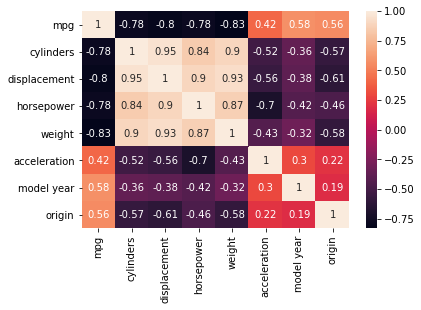

In [29]:
import seaborn as sns
corrmat = df.corr()
sns.heatmap(corrmat, annot = True)

**Variable à prédire (Y):** mpg  

**Variable explicative la plus corrélée (X) à la variable à prédire (Y):**   
Classement :  
- 1. **weight** avec une forte corrélation négative à **-0.83**  
- 2. **displacement** avec une forte corrélation négative à **-0.80**  
- 3. **horsepower** et **cylinders** avec une corrélation négative à **-0.7**

La matrice de corrélation nous permet de connaître les corrélations entres les différentes features (ligne a, colonne b).  
- Les valeurs proches de 1 démontrent d'une corrélation forte positive.  
- Les valeurs proches de -1 démontrent d'une corrélation forte négative.  
- Les valeurs proches de 0 démontrent d'une absence de corrélation.  

Pour la suite, j'ai donc décidé de choisir **weight** étant la variable la plus corrélée à la variable à prédire **mpg**



### 5.2. Régression linéaire sur les données complètes

In [77]:
# Afin d'avoir des données complètes, j'ai choisi d'imputer le dataset par knn

# Encodage des variables qualitatives en encodage numerique
df_knn = dataframe_labelEncoder(df, ['cylinders', 'model year', 'origin', 'car name'], verbose=False, scaler=True)

# Imputation des données manquantes par Knn
df_knn_imputed = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=2, weights="uniform").fit_transform(df_knn), columns=df_knn.columns)

# Verification des données imputées
print('Nombre de données manquantes pour chaque colonne:')
print(get_number_missing_data(df_knn_imputed), '\n')

Nombre de données manquantes pour chaque colonne:
mpg             0
displacement    0
horsepower      0
weight          0
acceleration    0
cylinders       0
model year      0
origin          0
car name        0
dtype: int64 



In [78]:
Y = df_knn_imputed.iloc[:,0]
X = df_knn_imputed.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

b) Déterminer les coefficients de la droite de régression (fonction fit) sur les données d’apprentissage.

In [79]:
LinearRegression().fit(X_train, y_train)

LinearRegression()

c) Effectuer les prédictions sur les données de test (fonction predict) et estimer les performances : RMSE (Root Mean Squared Error) et R2 (r2_score)

### 5.3. Régression linéaire sur les données manquantes après imputation
Répéter les expériences précédentes en considérant successivement 20% et 50% de données manquantes imputées.
Présenter les résultats sous forme d’un graphe comparatif que vous commenterez.

### 5.4. Pour finir...
Deux variables sont corrélées en valeur absolue... retournez au 5.1 pour vérifier la pertinence de votre choix.
Une corrélation linéaire peut être encore améliorée en transformant astucieusement les données : comment ?
En tenant compte de ces deux remarques, refaire les parties 5.2 et 5.3 si nécessaire. Une grossière erreur s’est glissée quelque part. La question est : où ? Expliquez.